# Crocoddyl: Contact RObot COntrol by Differential DYnamic programming Library


## I. Welcome to crocoddyl
Crocoddyl is an **optimal control library for robot control under contact sequence**. Its solver is based on an efficient Differential Dynamic Programming (DDP) algorithm. Crocoddyl computes optimal trajectories along to optimal feedback gains. It uses Pinocchio for fast computation of robot dynamics and its analytical derivatives. 

Crocoddyl is focused on multi-contact optimal control problem (MCOP) which as the form:

$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{k=1}^N \int_{t_k}^{t_k+\Delta t} l(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}),$$
$$ \mathbf{x}\in\mathcal{X}, \mathbf{u}\in\mathcal{U}, \boldsymbol{\lambda}\in\mathcal{K}.$$
where
 - the state $\mathbf{x}=(\mathbf{q},\mathbf{v})$ lies in a manifold, e.g. Lie manifold $\mathbf{q}\in SE(3)\times \mathbb{R}^{n_j}$,
 - the system has unactuacted dynamics, i.e. $\mathbf{u}=(\mathbf{0},\boldsymbol{\tau})$,
 - $\mathcal{X}$, $\mathcal{U}$ are the state and control admissible sets, and
 - $\mathcal{K}$ represents the contact constraints.
 
 Despite that $\boldsymbol{\lambda}=\mathbf{g}(\mathbf{x},\mathbf{u})$, we used it intentionally to clearly state the contact constraints.
 
Let's start by understanding the concept behind crocoddyl design.

# II. Action models

In crocoddyl, an action model combines dynamics and cost data. Each knot, in our optimal control problem, is described through an action model. Every time that we want describe a problem, we need to provide ways of computing the dynamics, cost functions and their derivatives. However, **we have implement NumDiff abstractions for debugging**.

If we locally linerized our optimal control problem, we get:

$$\mathbf{X}^*(\mathbf{x}_0),\mathbf{U}^*(\mathbf{x}_0)
=
\arg\max_{\mathbf{X},\mathbf{U}} = cost_T(\delta\mathbf{x}_N) + \sum_{k=1}^N cost_t(\delta\mathbf{x}_k, \delta\mathbf{u}_k)$$
subject to
$$dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k)=\mathbf{0},$$

where
$$cost_T(\delta\mathbf{x}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top \\
\mathbf{l_x} & \mathbf{l_{xx}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x}
\end{bmatrix}
$$

$$cost_t(\delta\mathbf{x},\delta\mathbf{u}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top & \mathbf{l_u}^\top\\
\mathbf{l_x} & \mathbf{l_{xx}} & \mathbf{l_{ux}}^\top\\
\mathbf{l_u} & \mathbf{l_{ux}} & \mathbf{l_{uu}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}
$$

$$
dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k) = \delta\mathbf{x}_{k+1} - (\mathbf{f_x}\delta\mathbf{x}_k + \mathbf{f_u}\delta\mathbf{u}_k)
$$

where an action model defines a time interval of this problem:
 - $action = dynamics + cost$

## II.a Differential and Integrated Action Models
Optimal control solvers require the time-discrete model of cost and dynamics. However, **it's often convenient to describe our model in continuous time**. For that, crocoddyl provides an action interface for continuous-time models, we call it "Differential Action Model". Along predefined integrated action models, the user can switch between different methods for discretization.

At the moment, we have:
 - a simpletic Euler integration rule (for the dynamics), together with
 - a rectangle quadrature rule (for cost function)

An integrated action models uses a model of the form:
$$\mathbf{X}^*(\mathbf{x}_0),\mathbf{U}^*(\mathbf{x}_0)
=
\arg\max_{\mathbf{X},\mathbf{U}} = cost_T(\delta\mathbf{x}_N) + \sum_{k=1}^N \int_{t_k}^{t_k+\Delta t} cost_t(\delta\mathbf{x}_k, \delta\mathbf{u}_k) dt$$
subject to
$$dynamics(\delta\mathbf{x}_{k+1},\delta\mathbf{x}_k,\delta\mathbf{u}_k)=\mathbf{0},$$

where
$$cost_T(\delta\mathbf{x}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top \\
\mathbf{l_x} & \mathbf{l_{xx}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x}
\end{bmatrix}
$$

$$cost_t(\delta\mathbf{x},\delta\mathbf{u}) = \frac{1}{2}
\begin{bmatrix} 
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}^\top
\begin{bmatrix}
0 & \mathbf{l_x}^\top & \mathbf{l_u}^\top\\
\mathbf{l_x} & \mathbf{l_{xx}} & \mathbf{l_{ux}}^\top\\
\mathbf{l_u} & \mathbf{l_{ux}} & \mathbf{l_{uu}}
\end{bmatrix}
\begin{bmatrix}
  1 \\ \delta\mathbf{x} \\ \delta\mathbf{u}
\end{bmatrix}
$$

$$
dynamics(\delta\mathbf{\dot{x}},\delta\mathbf{x},\delta\mathbf{u}) = \delta\mathbf{\dot{x}} - (\mathbf{f_x}\delta\mathbf{x} + \mathbf{f_u}\delta\mathbf{u})
$$


### Building a differential action model for forward dynamics
#### Loading the robot

Crocoddyl offers several robot models for benchmarking our optimal control solvers. At the time being, we have the follows: Talos arm, Talos humanoid, Talos legs and HyQ manipulators, humanoids and quadrupeds. The collection of Talos models can be downloaded in Ubuntu with the APT package *robotpkg-talos-data*.

In [1]:
from crocoddyl import loadTalosArm
import numpy as np

talos_arm = loadTalosArm()

# Defining a initial state
q0 = [0.173046, 1., -0.52366, 0., 0., 0.1, -0.005]
x0 = np.hstack([q0, np.zeros(talos_arm.model.nv)])

### calc and calcDiff
Optimal control solvers often need to compute a quadratic approximation of the action model (as previously described); this provides a search direction (computeDirection). Then it's needed to try the step along this direction (tryStep).

Typically calc and calcDiff are running by computeDirection and tryStep (inside the solver). These functions update the information of:
 - **calc**: update the next state and its cost value
 $$\delta\mathbf{\dot{x}}_{k+1} = \mathbf{f}(\delta\mathbf{x}_k,\mathbf{u}_k)$$
 - **calcDiff**: update the derivatives of the dynamics and cost (quadratic approximation)
 $$\mathbf{f_x}, \mathbf{f_u} \hspace{1em} (dynamics)$$
 $$\mathbf{l_x}, \mathbf{l_u}, \mathbf{l_{xx}}, \mathbf{l_{ux}}, \mathbf{l_{uu}} \hspace{1em} (cost)$$
 
 **As in Pinocchio, crocoddyl put all information inside data**, so avoiding dynamic reallocation.

In [2]:
from crocoddyl import StatePinocchio
from crocoddyl import CostModelSum
from crocoddyl import a2m
import numpy as np
import pinocchio


class DifferentialActionModelABA:
    def __init__(self,pinocchioModel):
        # The forward dynamics and its derivatives are computed with Pinocchio
        self.pinocchio = pinocchioModel
        self.nq,self.nv = self.pinocchio.nq, self.pinocchio.nv
        
        # Describes integrate, difference, Jacobian integrate and Jacobian difference
        # for any Pinocchio model
        self.State = StatePinocchio(self.pinocchio)
        
        # Keeps a stack of cost functions
        self.costs = CostModelSum(self.pinocchio)
        
        # Dimension of the state, and its tangent space, and control
        self.nx = self.State.nx
        self.ndx = self.State.ndx
        self.nout = self.nv
        self.nu = self.nv
        self.unone = np.zeros(self.nu)
    @property
    def ncost(self): return self.costs.ncost
    def createData(self): return DifferentialActionDataABA(self) # create the data needed for this model
    def calc(model,data,x,u=None):
        if u is None: u=model.unone
        nx,nu,nq,nv,nout = model.nx,model.nu,model.nq,model.nv,model.nout
        q = a2m(x[:nq]) # from np array to matrix
        v = a2m(x[-nv:]) # from np array to matrix
        tauq = a2m(u) # from np array to matrix
        
        # Computes the next state through ABA
        data.xout[:] = pinocchio.aba(model.pinocchio,data.pinocchio,q,v,tauq).flat
        
        # Updates the kinematics needed for cost computation
        pinocchio.forwardKinematics(model.pinocchio,data.pinocchio,q,v)
        pinocchio.updateFramePlacements(model.pinocchio,data.pinocchio)
        
        # Computes the cost from a set of single cost functions
        data.cost = model.costs.calc(data.costs,x,u)
        return data.xout,data.cost

    def calcDiff(model,data,x,u=None,recalc=True):
        if u is None: u=model.unone
        if recalc: xout,cost = model.calc(data,x,u)
        nx,ndx,nu,nq,nv,nout = model.nx,model.State.ndx,model.nu,model.nq,model.nv,model.nout
        q = a2m(x[:nq]) # from np array to matrix
        v = a2m(x[-nv:]) # from np array to matrix
        tauq = a2m(u) # from np array to matrix
        
        # Computes the ABA derivatives (dynamics), and keeps them inside data
        pinocchio.computeABADerivatives(model.pinocchio,data.pinocchio,q,v,tauq)
        data.Fx[:,:nv] = data.pinocchio.ddq_dq
        data.Fx[:,nv:] = data.pinocchio.ddq_dv
        data.Fu[:,:]   = pinocchio.computeMinverse(model.pinocchio,data.pinocchio,q)

        # Updates the kinematics Jacobians needed for getting the derivatives of the cost function
        pinocchio.computeJointJacobians(model.pinocchio,data.pinocchio,q)
        pinocchio.updateFramePlacements(model.pinocchio,data.pinocchio)
        
        # Computes all derivatives of cost function
        model.costs.calcDiff(data.costs,x,u,recalc=False)
        return data.xout,data.cost


class DifferentialActionDataABA:
    def __init__(self,model):
        self.pinocchio = model.pinocchio.createData()
        self.costs = model.costs.createData(self.pinocchio)
        self.cost = np.nan
        self.xout = np.zeros(model.nout)
        nx,nu,ndx,nq,nv,nout = model.nx,model.nu,model.State.ndx,model.nq,model.nv,model.nout
        self.F = np.zeros([ nout,ndx+nu ])
        self.costResiduals = self.costs.residuals
        self.Fx = self.F[:,:ndx]
        self.Fu = self.F[:,-nu:]
        self.g   = self.costs.g
        self.L   = self.costs.L
        self.Lx  = self.costs.Lx
        self.Lu  = self.costs.Lu
        self.Lxx = self.costs.Lxx
        self.Lxu = self.costs.Lxu
        self.Luu = self.costs.Luu
        self.Rx  = self.costs.Rx
        self.Ru  = self.costs.Ru

## II.b State and its integrate and difference rules
General speaking, the system's state can lie in a manifold $M$ and its tangent space $T_\mathbf{x}M$. There are few operators that needs to be defined for different rutines inside our solvers:
  - $\mathbf{x}_{k+1} = integrate(\mathbf{x}_k,\delta\mathbf{x}_k) = \mathbf{x}_k \oplus \delta\mathbf{x}_k$
  - $\delta\mathbf{x}_k = difference(\mathbf{x}_{k+1},\mathbf{x}_k) = \mathbf{x}_{k+1} \ominus \mathbf{x}_k$
 
 where $\mathbf{x}\in M$ and $\delta\mathbf{x}\in T_\mathbf{x} M$.
 
 And we also need to defined the Jacobians of these operators with respect to the first and second arguments:
  - $\frac{\partial \mathbf{x}\oplus\delta\mathbf{x}}{\partial \mathbf{x}}, \frac{\partial \mathbf{x}\oplus\delta\mathbf{x}}{\partial\delta\mathbf{x}} =Jintegrante(\mathbf{x},\delta\mathbf{x})$
  - $\frac{\partial\mathbf{x}_2\ominus\mathbf{x}_2}{\partial \mathbf{x}_1}, \frac{\partial \mathbf{x}_2\ominus\mathbf{x}_1}{\partial\mathbf{x}_1} =Jdifference(\mathbf{x}_2,\mathbf{x}_1)$

For instance, a state that lies in the Euclidean space will the typical operators:
  - $integrate(\mathbf{x},\delta\mathbf{x}) = \mathbf{x} + \delta\mathbf{x}$
  - $difference(\mathbf{x}_2,\mathbf{x}_1) = \mathbf{x}_2 - \mathbf{x}_1$
  - $Jintegrate(\cdot,\cdot) = Jdifference(\cdot,\cdot) = \mathbf{I}$
  

# TODO

# III. Solving optimal control problems with DDP

## III.a ABA dynamics for reaching a goal with Talos arm

Our optimal control solver interacts with the a formulated ShootingProblem. A shooting problem represents a stack of action models (for each knot along the trajectory).

First we need to create an action model from DifferentialActionModelABA. We use it from building terminal and running action models. In this example, we employ an simpletic Euler integration rule as follows:

In [3]:
from crocoddyl import IntegratedActionModelEuler

# Running and terminal action models
runningModel = IntegratedActionModelEuler(DifferentialActionModelABA(talos_arm.model))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelABA(talos_arm.model))

# Defining the time duration for running action models and the terminal one
dt = 1e-3
runningModel.timeStep = dt

Next we define the set of cost functions for this problem. For this particular example, we formulate three running-cost functions: 
 - goal-tracking cost, $log(^fXd_o \,^oX_f)$
   
 - state and control regularization; and $\|\mathbf{x}-\mathbf{x}_{ref}\|, \|\mathbf{u}\|$

one terminal-cost:
 - goal cost. $\|\mathbf{u}_T\|$
 
 First, let's create the common cost functions.

In [4]:
from crocoddyl import CostModelPosition6D, CostModelState, CostModelControl
from crocoddyl import m2a
from pinocchio.utils import *
import pinocchio

# Goal tracking cost
frameName = 'gripper_left_joint' #gripper_left_fingertip_2_link'
state = StatePinocchio(talos_arm.model)
SE3ref = pinocchio.SE3(np.eye(3), np.array([ [.0],[.0],[.4] ]))
goalTrackingCost = CostModelPosition6D(talos_arm.model,
                                       nu=talos_arm.model.nv,
                                       frame=talos_arm.model.getFrameId(frameName),
                                       ref=SE3ref)

# State and control regularization
xRegCost = CostModelState(talos_arm.model,
                          state,
                          ref=state.zero(),
                          nu=talos_arm.model.nv)
uRegCost = CostModelControl(talos_arm.model,nu=talos_arm.model.nv)

# Adds the running and terminal cost functions
runningCostModel = runningModel.differential.costs
runningCostModel.addCost( name="pos", weight = 1e-3, cost = goalTrackingCost)
runningCostModel.addCost( name="regx", weight = 1e-7, cost = xRegCost) 
runningCostModel.addCost( name="regu", weight = 1e-7, cost = uRegCost)
terminalCostModel = terminalModel.differential.costs
terminalCostModel.addCost( name="pos", weight = 1, cost = goalTrackingCost)


# Let's compute the cost and its derivatives
robot_data = talos_arm.model.createData() # Pinocchio data
data = goalTrackingCost.createData(robot_data)

# Update kinematics
q = pinocchio.randomConfiguration(talos_arm.model)
v = rand(talos_arm.model.nv)
x = m2a(np.concatenate([q,v]))
u = m2a(rand(talos_arm.model.nv))
pinocchio.forwardKinematics(talos_arm.model,robot_data,q,v)
pinocchio.computeJointJacobians(talos_arm.model,robot_data,q)
pinocchio.updateFramePlacements(talos_arm.model,robot_data)

print 'cost =', goalTrackingCost.calc(data, x, u)
print 'cost =', goalTrackingCost.calcDiff(data, x, u)
print
print 'lx =', data.Lx
print 'lu =', data.Lu
print
print 'lxx =', data.Lxx
print 'luu =', data.Luu

cost = 1.4684685334690646
cost = 1.4684685334690646

lx = [-0.02506849  0.94403488 -0.86340922  0.50823898  0.09167757 -1.4506146
  0.05300068  0.          0.          0.          0.          0.
  0.          0.        ]
lu = 0

lxx = [[ 1.21572618  0.00515111 -0.32902714 -1.06863146  0.08235006 -0.03620446
   0.09630369  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.00515111  1.11391884  0.07378636  0.35897045  0.86614084 -0.6659405
   0.85891928  0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.32902714  0.07378636  1.16180519  0.04079667  0.77781306  0.7934481
   0.77219398  0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.06863146  0.35897045  0.04079667  1.21236999 -0.05802136 -0.35395725
  -0.10011896  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.08235006  0.86614084  0.77781306 -0.05802136  1.30764328  0.04966493
   1.3439346   0.        

We create a trajectory with 250 knots

In [5]:
from crocoddyl import ShootingProblem

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 250
problem = ShootingProblem(x0, [ runningModel ]*T, terminalModel)

Onces we have defined our shooting problem, we create a DDP solver object and pass some callback functions for analysing  its performance.

Please note that:
- CallbackDDPLogger: store the solution information.
- CallbackDDPVerbose(level): printing message during the iterates.
- CallbackSolverDisplay(robot,rate): display the state trajectory using Gepetto viewer.

In [6]:
from crocoddyl import SolverDDP
from crocoddyl import CallbackDDPLogger, CallbackDDPVerbose, CallbackSolverDisplay

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverDDP(problem)
cameraTF = [2., 2.68, 0.54, 0.2, 0.62, 0.72, 0.22]
ddp.callback = [CallbackDDPLogger(), CallbackDDPVerbose(1), CallbackSolverDisplay(talos_arm,4,cameraTF)]

# Solving it with the DDP algorithm
ddp.solve()

# Printing the reached position
log = ddp.callback[0]
frame_idx = talos_arm.model.getFrameId(frameName)
xT = log.xs[-1]
qT = np.asmatrix(xT[:talos_arm.model.nq]).T
print
print "The reached pose by the wrist is"
print talos_arm.framePlacement(qT, frame_idx)

iter 	 cost 	      theta 	    gamma 	  muV 	      muLM 	 alpha 	   dV-exp 	  dV
   0  3.33784e-01  2.79313e-08  2.46733e-01  1.00000e-09  1.00000e-09  1.0000  1.23366e-01  3.23000e-01
   1  2.76830e-01  4.07640e-08  2.51704e-01  1.00000e-09  1.00000e-09  0.2500  5.50602e-02  5.69540e-02
   2  2.41482e-01  2.71532e-08  1.67983e-01  1.00000e-09  1.00000e-09  0.2500  3.67462e-02  3.53480e-02
   3  2.14120e-01  1.92516e-08  1.23269e-01  1.00000e-09  1.00000e-09  0.2500  2.69651e-02  2.73627e-02
   4  1.92160e-01  1.36544e-08  9.38145e-02  1.00000e-09  1.00000e-09  0.2500  2.05219e-02  2.19594e-02
   5  1.73479e-01  1.04796e-08  7.84493e-02  1.00000e-09  1.00000e-09  0.2500  1.71608e-02  1.86811e-02
   6  1.56354e-01  8.92818e-09  7.20415e-02  1.00000e-09  1.00000e-09  0.2500  1.57591e-02  1.71248e-02
   7  1.41779e-01  7.25090e-09  6.08715e-02  1.00000e-09  1.00000e-09  0.2500  1.33156e-02  1.45751e-02
   8  1.32226e-01  4.76111e-09  4.04640e-02  1.00000e-09  1.00000e-09  0.2500  8.85149e-

Let's plot the results and display final trajectory

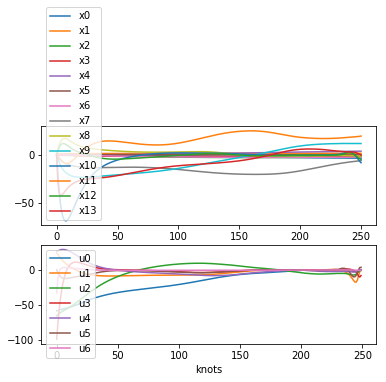

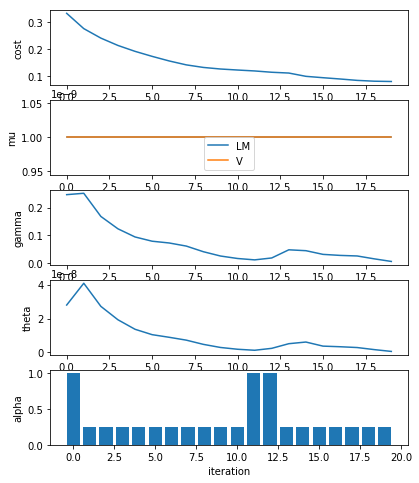

In [8]:
from crocoddyl import plotOCSolution, plotDDPConvergence

# Plotting the solution and the DDP convergence
log = ddp.callback[0]
plotOCSolution(log.xs, log.us)
plotDDPConvergence(log.costs,log.control_regs,
                   log.state_regs,log.gm_stops,
                   log.th_stops,log.steps)

# Visualizing the solution in gepetto-viewer
CallbackSolverDisplay(talos_arm)(ddp)

## III.b Multi-Contact dynamics for biped walking (Talos legs)
In this example, we describe the multi-contact dynamics through holonomic constraints for the support legs. From the Gauss principle, we have derived the model as:
$$
\left[\begin{matrix}
 \mathbf{M} & \mathbf{J}^{\top}_c \\
 {\mathbf{J}_{c}} & \mathbf{0} \\
\end{matrix}\right]
\left[\begin{matrix}
 \dot{\mathbf{v}} \\ -\boldsymbol{\lambda}
\end{matrix}\right]
 = 
\left[\begin{matrix}
  \boldsymbol{\tau} - \mathbf{h} \\
  -\dot{\mathbf{J}}_c \mathbf{v} \\
\end{matrix}\right]$$.


Base on a predefined walking gait, we build per each phase a specific multi-contact dynamics. Indeed we need to describe multi-phase optimal control problem. One can formulate the multi-contact optimal control problem (MCOP) as follows:


$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{p=0}^P \sum_{k=1}^{N(p)} \int_{t_k}^{t_k+\Delta t} l_p(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}_p(\mathbf{x},\mathbf{u}), \text{for } t \in [\tau_p,\tau_{p+1}]$$

$$ \mathbf{g}(\mathbf{v}^{p+1},\mathbf{v}^p) = \mathbf{0}$$

$$ \mathbf{x}\in\mathcal{X}_p, \mathbf{u}\in\mathcal{U}_p, \boldsymbol{\lambda}\in\mathcal{K}_p.$$

where $\mathbf{g}(\cdot,\cdot,\cdot)$ describes the contact dynamics, and they represents terminal constraints in each walking phase. In this example we use the following impact model:

$$\mathbf{M}(\mathbf{v}_{next}-\mathbf{v}) = \mathbf{J}_{impulse}^T$$

$$\mathbf{J}_{impulse} \mathbf{v}_{next} = \mathbf{0}$$

$$\mathbf{J}_{c} \mathbf{v}_{next} = \mathbf{J}_{c} \mathbf{v}$$



First, let's define walking shooting problem:

In [9]:
from crocoddyl import StatePinocchio
from crocoddyl import DifferentialActionModelFloatingInContact
from crocoddyl import IntegratedActionModelEuler
from crocoddyl import CostModelSum
from crocoddyl import CostModelPosition6D, CostModelPlacementVelocity
from crocoddyl import CostModelState, CostModelControl
from crocoddyl import ActuationModelFreeFloating
from crocoddyl import ContactModel6D, ContactModelMultiple
from crocoddyl import ShootingProblem


class SE3Task:
    def __init__(self, oXf, frameId):
        self.oXf = oXf
        self.frameId = frameId


class SimpleBipedWalkingProblem:
    """ Defines a simple 3d locomotion problem
    """
    def __init__(self, robot, rightFoot, leftFoot):
        self.robot = robot
        self.state = StatePinocchio(self.robot.model)
        self.rightFoot = rightFoot
        self.leftFoot = leftFoot

    def createProblem(self, x, stepLength, stepDuration):
        # Computing the time step per each contact phase given the step duration.
        # Here we assume a constant number of knots per phase
        numKnots = 20
        timeStep = float(stepDuration)/numKnots

        # Getting the frame id for the right and left foot
        rightFootId = self.robot.model.getFrameId(self.rightFoot)
        leftFootId = self.robot.model.getFrameId(self.leftFoot)

        # Compute the current foot positions
        q0 = a2m(x[:self.robot.nq])
        rightFootPos0 = self.robot.framePlacement(q0, rightFootId).translation
        leftFootPos0 = self.robot.framePlacement(q0, leftFootId).translation

        # Defining the action models along the time instances
        n_cycles = 2
        loco3dModel = []
        import copy
        for i in range(n_cycles):
            # swing LF phase
            leftSwingModel = \
                [ self.createContactPhaseModel(
                    timeStep,
                    rightFootId,
                    SE3Task(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ [(stepLength*k)/numKnots, 0., 0.] ]) +
                                      leftFootPos0)),
                        leftFootId)
                    ) for k in range(numKnots) ]
            
            # Double support phase
            doubleSupportModel = \
                self.createContactSwitchModel(
                    rightFootId,
                    SE3Task(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ stepLength, 0., 0. ]) +
                                      leftFootPos0)),
                        leftFootId)
                    )
            
            # swing RF phase
            rightSwingModel = \
                [ self.createContactPhaseModel(
                    timeStep,
                    leftFootId,
                    SE3Task(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ 2*(stepLength*k)/numKnots, 0., 0. ]) +
                                      rightFootPos0)),
                        rightFootId)
                    ) for k in range(numKnots) ]
            
            # Final support phase
            finalSupport = \
                self.createContactSwitchModel(
                    leftFootId,
                    SE3Task(
                        pinocchio.SE3(np.eye(3),
                                      np.asmatrix(a2m([ 2*stepLength, 0., 0. ]) +
                                      rightFootPos0)),
                        rightFootId),
                    )
            rightFootPos0 += np.asmatrix(a2m([ stepLength, 0., 0. ]))
            leftFootPos0 += np.asmatrix(a2m([ stepLength, 0., 0. ]))
            loco3dModel += leftSwingModel + [ doubleSupportModel ] + rightSwingModel + [ finalSupport ]

        problem = ShootingProblem(x, loco3dModel, finalSupport)
        return problem

    def createContactPhaseModel(self, timeStep, contactFootId, footSwingTask):
        # Creating the action model for floating-base systems. A walker system 
        # is by default a floating-base system
        actModel = ActuationModelFreeFloating(self.robot.model)

        # Creating a 6D multi-contact model, and then including the supporting
        # foot
        contactModel = ContactModelMultiple(self.robot.model)
        contactFootModel = \
            ContactModel6D(self.robot.model, contactFootId, ref=None)
        contactModel.addContact('contact', contactFootModel)

        # Creating the cost model for a contact phase
        costModel = CostModelSum(self.robot.model, actModel.nu)
        footTrack = CostModelPosition6D(self.robot.model,
                                        footSwingTask.frameId,
                                        footSwingTask.oXf,
                                        actModel.nu)
        stateReg = CostModelState(self.robot.model,
                                  self.state,
                                  self.state.zero(),
                                  actModel.nu)
        stateReg.weights = \
            np.array([0]*6 + [0.01]*(self.robot.model.nv-6) + [10]*self.robot.model.nv)
        ctrlReg = CostModelControl(self.robot.model, actModel.nu)
        costModel.addCost("footTrack", footTrack, 100.)
        costModel.addCost("stateReg", stateReg, 0.1)
        costModel.addCost("ctrlReg", ctrlReg, 0.001)

        # Creating the action model for the KKT dynamics with simpletic Euler
        # integration scheme
        dmodel = \
            DifferentialActionModelFloatingInContact(self.robot.model,
                                                     actModel,
                                                     contactModel,
                                                     costModel)
        model = IntegratedActionModelEuler(dmodel)
        model.timeStep = timeStep
        return model

    def createContactSwitchModel(self, contactFootId, swingFootTask):
        model = self.createContactPhaseModel(0., contactFootId, swingFootTask)

        impactFootVelCost = \
            CostModelPlacementVelocity(self.robot.model, swingFootTask.frameId)
        model.differential.costs.addCost('impactVel', impactFootVelCost, 10000.)
        model.differential.costs['impactVel' ].weight = 100000
        model.differential.costs['footTrack' ].weight = 100000
        model.differential.costs['stateReg'].weight = 1
        model.differential.costs['ctrlReg'].weight = 0.01
        return model

This class builds action models for each locomotion phase:
  - createContactPhaseModel: defines an action model for the swing phase
  - createContactSwitchModel: defines an action model for switch knots between phases
  
Then we build a walking by combining a set of contact phases and their contact switches.

Now let's create a walking OC problem for the Talos legs.

iter 	 cost 	      theta 	    gamma 	  muV 	      muLM 	 alpha
   0  1.75872e+06  3.98534e+06  1.01608e+06  1.00000e-02  1.00000e-02  1.0000
   1  6.60121e+05  9.28539e+08  3.50823e+06  1.00000e-03  1.00000e-03  1.0000
   2  1.93867e+05  3.47290e+08  1.31840e+06  1.00000e-04  1.00000e-04  1.0000
   3  4.86463e+03  6.02376e+07  3.86684e+05  1.00000e-05  1.00000e-05  1.0000
   4  2.83783e+03  1.06563e+06  8.82042e+03  1.00000e-06  1.00000e-06  1.0000
   5  4.71728e+02  1.30635e+06  4.77260e+03  1.00000e-07  1.00000e-07  1.0000
   6  4.51319e+02  9.25467e+03  4.08153e+01  1.00000e-08  1.00000e-08  1.0000
   7  4.51314e+02  1.41238e-01  9.60388e-03  1.00000e-09  1.00000e-09  1.0000
   8  4.51314e+02  7.81621e-04  4.87315e-04  1.00000e-09  1.00000e-09  1.0000
   9  4.51314e+02  2.02318e-06  3.01584e-05  1.00000e-09  1.00000e-09  1.0000
iter 	 cost 	      theta 	    gamma 	  muV 	      muLM 	 alpha
  10  4.51314e+02  1.90932e-07  1.91847e-06  1.00000e-09  1.00000e-09  1.0000
  11  4.51314e+0

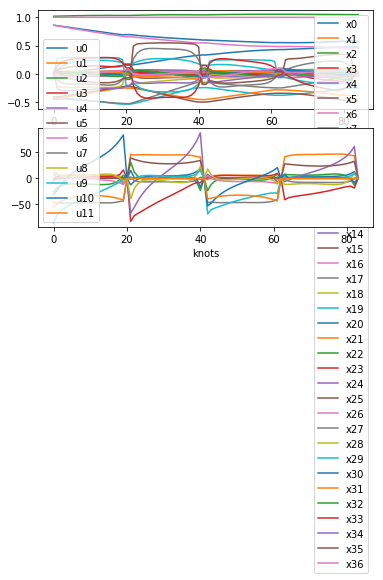

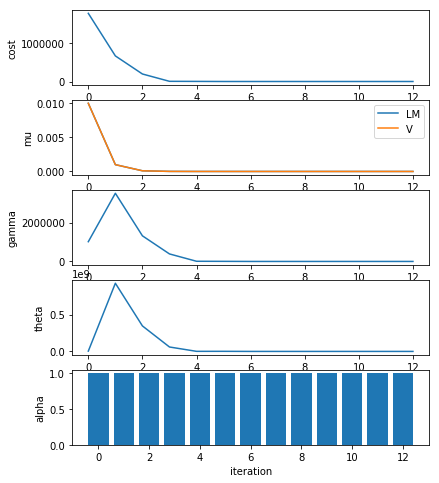

In [9]:
from crocoddyl import loadTalosLegs
from crocoddyl import m2a
from pinocchio.utils import *

talos_legs = loadTalosLegs()
talos_legs.model.armature[6:] = 1. #No armature

# Setting up the 3d walking problem
rightFoot = 'right_sole_link'
leftFoot = 'left_sole_link'
walk = SimpleBipedWalkingProblem(talos_legs, rightFoot, leftFoot)


# Create the initial state
q = talos_legs.q0.copy()
v = zero(talos_legs.model.nv)
x = m2a(np.concatenate([q,v]))

# Solving the 3d walking problem using DDP
stepLength = 0.2
stepDuration = 0.75
ddp = SolverDDP(walk.createProblem(x, stepLength, stepDuration))
cameraTF = [3., 3.68, 0.84, 0.2, 0.62, 0.72, 0.22]
ddp.callback = [CallbackDDPLogger(), CallbackDDPVerbose(), CallbackSolverDisplay(talos_legs,4,cameraTF)]
ddp.th_stop = 1e-9
ddp.solve(maxiter=1000,regInit=.1)

# Plotting the solution and the DDP convergence
log = ddp.callback[0]
plotOCSolution(log.xs, log.us)
plotDDPConvergence(log.costs,log.control_regs,
                   log.state_regs,log.gm_stops,
                   log.th_stops,log.steps)


Let's display again the optimal trajectory computed with our DDP solver:

In [ ]:
CallbackSolverDisplay(talos_legs)(ddp)

## Reference

The material presented in this Notebook was previously presented at the ICHR at 2018. For more information, please read the following paper:

R. Budhiraja, J. Carpentier, C. Mastalli and N. Mansard. *Differential Dynamic Programming for Multi-Phase Rigid Contact Dynamics*

In [17]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/X82tFTR4Mcc?start=11" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

https://cmastalli.github.io/assets/img/publications/astronaut360_v2.png



![title](https://cmastalli.github.io/assets/img/publications/astronaut360_v2.png)